In [31]:
import random
import os
import xml.etree.ElementTree as ET
from collections import Counter
import math
import warnings

import json
import argparse
import networkx as nx
import matplotlib.pyplot as plt

from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable , LpMinimize ,PULP_CBC_CMD ,SCIP_CMD,SCIP_PY,GUROBI_CMD
from LinProg_lib import *

from itertools import combinations

import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import colormaps

debug=True




In [32]:
# ======================================================================
# Create the Graph for the NoC in this example 4x4 mesh
# ======================================================================


mesh_size = 4
G_NoC = nx.DiGraph()

# Add nodes
for y in range(mesh_size):
    for x in range(mesh_size):
        G_NoC.add_node(coord_to_number(y, x,4))

# mesh
for y in range(mesh_size):
    for x in range(mesh_size):
        if y < mesh_size - 1:  # Connect to the node below
            G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 1, x,4))
            G_NoC.add_edge(coord_to_number(y + 1, x,4), coord_to_number(y, x,4))
        if x < mesh_size - 1:  # Connect to the node to the right
            G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y, x + 1,4))
            G_NoC.add_edge(coord_to_number(y, x + 1,4), coord_to_number(y, x,4))


# #folded torus
# for y in range(mesh_size):
#     for x in range(mesh_size):
#         if y < mesh_size - 2:  # Connect to the node below
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 2, x,4))
#             G_NoC.add_edge(coord_to_number(y + 2, x,4), coord_to_number(y, x,4))
#         if x < mesh_size - 2:  # Connect to the node to the right
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y, x + 2,4))
#             G_NoC.add_edge(coord_to_number(y, x + 2,4), coord_to_number(y, x,4))

#         if y==0:
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y +1, x,4))
#             G_NoC.add_edge(coord_to_number(y+1, x,4), coord_to_number(y, x,4))
#         if x==0:
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y, x+1,4))
#             G_NoC.add_edge(coord_to_number(y, x+1,4), coord_to_number(y, x,4))
#         if y==mesh_size-1:
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y -1, x,4))
#             G_NoC.add_edge(coord_to_number(y-1, x,4), coord_to_number(y, x,4))
#         if x==mesh_size-1:
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y, x-1,4))
#             G_NoC.add_edge(coord_to_number(y, x-1,4), coord_to_number(y, x,4))


#mesh with diagonal connections
# for y in range(mesh_size):
#     for x in range(mesh_size):
#         if y < mesh_size - 1:  # Connect to the node below
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 1, x,4))
#             G_NoC.add_edge(coord_to_number(y + 1, x,4), coord_to_number(y, x,4))
#         if x < mesh_size - 1:  # Connect to the node to the right
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y, x + 1,4))
#             G_NoC.add_edge(coord_to_number(y, x + 1,4), coord_to_number(y, x,4))
#         # Add diagonal connections (down-right and down-left)
#         if y < mesh_size - 1 and x < mesh_size - 1:
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 1, x + 1,4))
#             G_NoC.add_edge(coord_to_number(y + 1, x + 1,4), coord_to_number(y, x,4))
#         if y < mesh_size - 1 and x > 0:
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 1, x - 1,4))
#             G_NoC.add_edge(coord_to_number(y + 1, x - 1,4), coord_to_number(y, x,4))

#         if (y == 0 and x == 0) and y < mesh_size - 1 and x < mesh_size - 1:
#             # Top-left corner: down-right diagonal
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 1, x + 1,4))
#             G_NoC.add_edge(coord_to_number(y + 1, x + 1,4), coord_to_number(y, x,4))
#         if (y == 0 and x == mesh_size - 1) and y < mesh_size - 1 and x > 0:
#             # Top-right corner: down-left diagonal
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 1, x - 1,4))
#             G_NoC.add_edge(coord_to_number(y + 1, x - 1,4), coord_to_number(y, x,4))
#         if (y == mesh_size - 1 and x == 0) and y > 0 and x < mesh_size - 1:
#             # Bottom-left corner: up-right diagonal
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y - 1, x + 1,4))
#             G_NoC.add_edge(coord_to_number(y - 1, x + 1,4), coord_to_number(y, x,4))
#         if (y == mesh_size - 1 and x == mesh_size - 1) and y > 0 and x > 0:
#             # Bottom-right corner: up-left diagonal
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y - 1, x - 1,4))
#             G_NoC.add_edge(coord_to_number(y - 1, x - 1,4), coord_to_number(y, x,4))


# for y in range(mesh_size):
#     for x in range(mesh_size):
#         if y < mesh_size - 1:  # Connect to the node below
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 1, x,4))
#             G_NoC.add_edge(coord_to_number(y + 1, x,4), coord_to_number(y, x,4))
#         if x < mesh_size - 1:  # Connect to the node to the right
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y, x + 1,4))
#             G_NoC.add_edge(coord_to_number(y, x + 1,4), coord_to_number(y, x,4))
#         # Add diagonal connections only in the corners, but not to the outermost diagonal
# G_NoC.add_edge(1, 4)
# G_NoC.add_edge(4, 1)

# G_NoC.add_edge(2, 7)
# G_NoC.add_edge(7, 2)

# G_NoC.add_edge(8, 13)
# G_NoC.add_edge(13, 8)

# G_NoC.add_edge(14, 11)
# G_NoC.add_edge(11, 14)

#mesh with other diagonal connections
# for y in range(mesh_size):
#     for x in range(mesh_size):
#         if y < mesh_size - 1 and (x==0 or x==mesh_size - 1):  # Connect to the node below
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 1, x,4))
#             G_NoC.add_edge(coord_to_number(y + 1, x,4), coord_to_number(y, x,4))
#         if x < mesh_size - 1 and (y==0 or y==mesh_size - 1):  # Connect to the node to the right
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y, x + 1,4))
#             G_NoC.add_edge(coord_to_number(y, x + 1,4), coord_to_number(y, x,4))
#         # Add diagonal connections (down-right and down-left)
#         if y < mesh_size - 1 and x < mesh_size - 1:
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 1, x + 1,4))
#             G_NoC.add_edge(coord_to_number(y + 1, x + 1,4), coord_to_number(y, x,4))
#         if y < mesh_size - 1 and x > 0:
#             G_NoC.add_edge(coord_to_number(y, x,4), coord_to_number(y + 1, x - 1,4))
#             G_NoC.add_edge(coord_to_number(y + 1, x - 1,4), coord_to_number(y, x,4))




if debug==True:

    elements = graph_to_cytoscape(G_NoC)

    # Dash App
    app = dash.Dash(__name__)

    app.layout = html.Div([
        html.H3("Drag and Move Nodes in Real Time"),
        cyto.Cytoscape(
            id="cytoscape-graph",
            elements=elements,
            layout={"name": "preset"},  # Use preset positions
            style={"width": "100%", "height": "600px"},
            stylesheet=[
                {"selector": "node", "style": {
                    "content": "data(label)",
                    "background-color": "lightblue",
                    "width": "75px",  # Increase node size
                    "height": "75px",  # Increase node size
                    "font-size": "16px",  # Make labels larger
                    "text-valign": "center",
                }},
                {"selector": "edge", "style": {
                    "curve-style": "bezier",
                    "target-arrow-shape": "triangle",
                    "label": "data(label)",
                    "font-size": "12px",
                    "color": "white",  # Make edge labels white
                }}
            ],
        ),
    ])

    if __name__ == "__main__":
        import socket
        port = 8050
        while True:
            with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
                if s.connect_ex(("localhost", port)) != 0:  # Port is available
                    break
                port += 1  # Try the next port
        app.run(debug=True, port=port)

[[(3, 2.2), (3, 3.7)], [(3, 3.7), (3.2, 3.7)], [(3.2, 3.7), (3.2, 3.2)]]
Edge: (11, 15), Start: (3, 2.2), End: (3, 3.7)
Edge: (11, 15), Start: (3, 3.7), End: (3.2, 3.7)
Edge: (11, 15), Start: (3.2, 3.7), End: (3.2, 3.2)


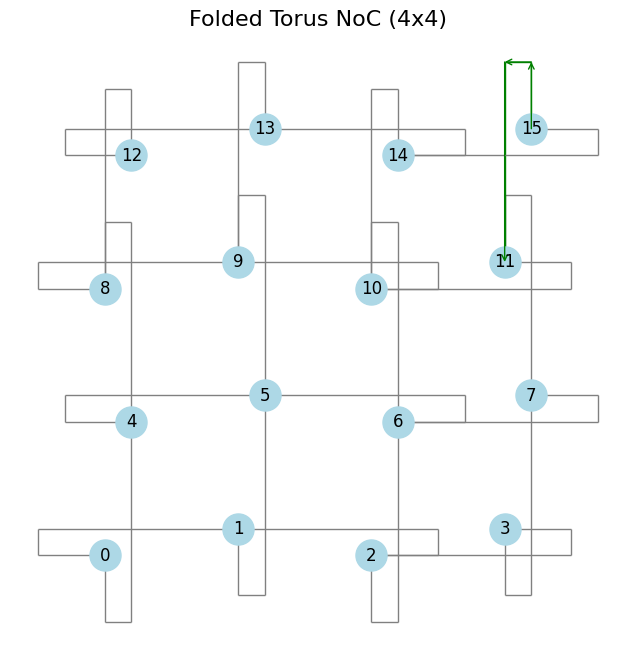

In [33]:

highlight_edges_with_colors = {
    (1, 9): "red",
    (11, 3): "blue",
    (15, 11): "green",
    (5, 7): "green",
}

draw_folded_torus_noc(
    mesh_size=4,
    G_NoC=G_NoC,
    highlight_edges_with_colors=highlight_edges_with_colors,
    title="Folded Torus NoC (4x4)"
)

In [34]:
# ======================================================================
# Use the PE graph to create inputs to be used by the NoC mapping LP
# ======================================================================


import networkx as nx
from LinProg_lib import draw_networkx_graph

G = nx.read_graphml("PE_graph.graphml")


# ======================================================================
# Check for src and dst
# ======================================================================
nodes_with_src_true = [node for node, attrs in G.nodes(data=True) if attrs.get('src') == True]
nodes_with_dst_true = [node for node, attrs in G.nodes(data=True) if attrs.get('dst') == True]

if len(nodes_with_src_true) == 1:
    src= nodes_with_src_true[0]
else:
    raise ValueError("There are multiple source nodes or no source nodes found.")
if len(nodes_with_dst_true) == 1: 
    dst= nodes_with_dst_true[0]
else:
    raise ValueError("There are multiple destination nodes or no destination nodes found.")


# Extract all parallel paths between src and dst
parallel_paths = list(nx.all_simple_paths(G, source=src, target=dst))
print(f"Parallel paths between {src} and {dst} are {parallel_paths}")

# ======================================================================
# are there intermediate nodes which create new parallel paths and need
# to be split to multiple parallel paths (mid_start node)
# ======================================================================
nodes_with_unequal_io = []
for node in G.nodes:
    in_degree = G.in_degree(node)
    out_degree = G.out_degree(node)
    # if in_degree != out_degree and node != src and node != dst:
    #     nodes_with_unequal_io.append(node)
    if (in_degree >1 or out_degree>1) and node != src and node != dst:
        nodes_with_unequal_io.append(node)
# nodes_with_unequal_io.append('14')
# # nodes_with_unequal_io.append('0')
# nodes_with_unequal_io.append('44')
print(f"Nodes with unequal in and out degree: {nodes_with_unequal_io}")
# ======================================================================
# edges which are not part of the parallel paths are paths not going 
# from src to destination but the need to be added anyway
# ======================================================================
parallel_paths_edges=[]
for path in parallel_paths:
    for idx,node in enumerate(path[:-1]):
        parallel_paths_edges.append((node,path[idx+1]))


for edge in G.edges:
    if edge not in parallel_paths_edges:
        for path in parallel_paths:
            if edge[0] in path:
                nodes_with_unequal_io.append(edge[0])
        parallel_paths.append([edge[0],edge[1]])
        
nodes_with_unequal_io=list(set(nodes_with_unequal_io))
print(f"parallel_paths_edges: {parallel_paths}")
print(f"Nodes with unequal in and out degree: {nodes_with_unequal_io}")
# for path in parallel_paths:

# ======================================================================
# paths with mid_start node need to be split up
# ======================================================================


# Repeat the splitting process until no further splitting is required
paths_need_splitting = True
while paths_need_splitting:
    paths_need_splitting = False  # Assume no splitting is needed
    new_parallel_paths = []  # Temporary list to store updated paths

    for path in parallel_paths:
        split_occurred = False
        for node in nodes_with_unequal_io:
            if node in path and node != path[0] and node != path[-1]:
                index = path.index(node)
                part1 = path[:index + 1]
                part2 = path[index:]
                new_parallel_paths.append(part1)
                new_parallel_paths.append(part2)
                split_occurred = True
                paths_need_splitting = True  # Indicate that further splitting is needed
                break  # Stop checking this path further since it has been split
        if not split_occurred:
            new_parallel_paths.append(path)  # Keep the path as is if no split occurred

    parallel_paths = new_parallel_paths  # Update the paths with the newly split paths
# Remove duplicate paths from the final parallel paths
unique_parallel_paths = []
seen_paths = set()
for path in parallel_paths:
    path_tuple = tuple(path)  # Convert the path to a tuple for hashing
    if path_tuple not in seen_paths:
        seen_paths.add(path_tuple)
        unique_parallel_paths.append(path)  # Add the original list path to the unique list

parallel_paths = unique_parallel_paths  # Update the parallel_paths with unique paths



print(f"Updated parallel paths after splitting: {parallel_paths}")
# ======================================================================
# Get the number of hops for each path
# ======================================================================
hop_count = []
for path in parallel_paths:
    print(f"Path: {path}")
    hop_count.append(len(path) - 1)
    print(f"Number of hops: {len(path) - 1}")


# ======================================================================
# Combine src and dst nodes that are mapped to the same PE
# ======================================================================
src_dst_mapping = {}

for idx, path in enumerate(parallel_paths):
    src_key = f"src_{idx}"
    src_dst_mapping[src_key] = path[0] 

for idx, path in enumerate(parallel_paths):
    dst_key = f"dst_{idx}"
    src_dst_mapping[dst_key] = path[-1]  


# Group sources and destinations with the same values into sublists
same_value_groups = []

for key, value in src_dst_mapping.items():
    # Check if the value already exists in any group
    added = False
    for group in same_value_groups:
        if value in [src_dst_mapping[item] for item in group]:
            group.append(key)
            added = True
            break
    # If the value is not in any group, create a new group
    if not added:
        same_value_groups.append([key])

        # Remove sublists with length less than 2
same_value_groups = [group for group in same_value_groups if len(group) >= 2]


# ======================================================================
# needs to be tested with different graphs
# ======================================================================



Parallel paths between 0 and 53 are [['0', '4', '10', '11', '17', '35', '53'], ['0', '4', '11', '17', '35', '53']]
Nodes with unequal in and out degree: ['4', '11']
parallel_paths_edges: [['0', '4', '10', '11', '17', '35', '53'], ['0', '4', '11', '17', '35', '53'], ['53', '62'], ['62', '53']]
Nodes with unequal in and out degree: ['11', '4', '62', '53']
Updated parallel paths after splitting: [['0', '4'], ['4', '10', '11'], ['11', '17', '35', '53'], ['4', '11'], ['53', '62'], ['62', '53']]
Path: ['0', '4']
Number of hops: 1
Path: ['4', '10', '11']
Number of hops: 2
Path: ['11', '17', '35', '53']
Number of hops: 3
Path: ['4', '11']
Number of hops: 1
Path: ['53', '62']
Number of hops: 1
Path: ['62', '53']
Number of hops: 1


Set parameter Username
Set parameter LicenseID to value 2631888
Set parameter TimeLimit to value 60
Set parameter LogFile to value "gurobi.log"
Set parameter Threads to value 26
Using license file /home/sfischer/Software/gurobi12.0.1_linux64/gurobi1201/gurobi.lic
Academic license - for non-commercial use only - expires 2026-03-06

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.2 LTS")
Copyright (c) 2025, Gurobi Optimization, LLC

Read LP format model from file /tmp/d15c7784f22542d08e6079669283e281-pulp.lp
Reading time = 0.00 seconds
OBJ: 4724 rows, 1219 columns, 15780 nonzeros

Using Gurobi shared library /home/sfischer/Software/gurobi12.0.1_linux64/gurobi1201/linux64/lib/libgurobi.so.12.0.1

CPU model: Intel(R) Core(TM) i7-14700KF, instruction set [SSE2|AVX|AVX2]
Thread count: 28 physical cores, 28 logical processors, using up to 26 threads

Non-default parameters:
TimeLimit  60
Threads  26

Optimize a model with 4724 rows, 1219 columns and 15780 nonzeros
Mo

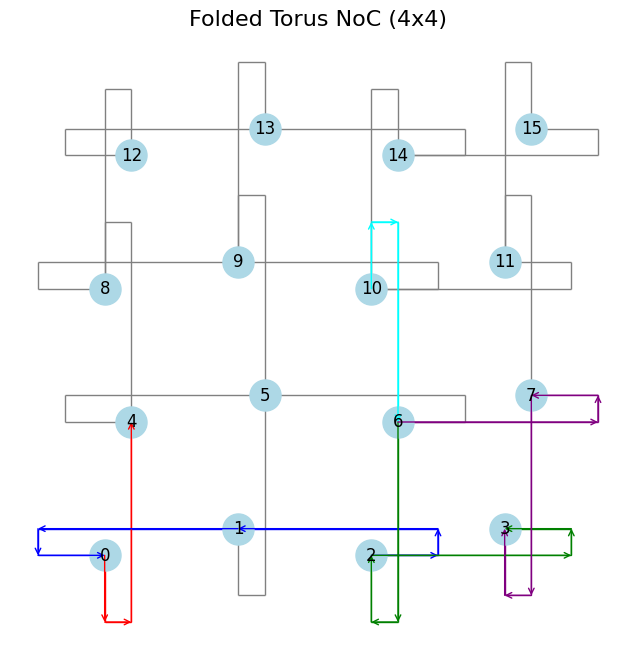

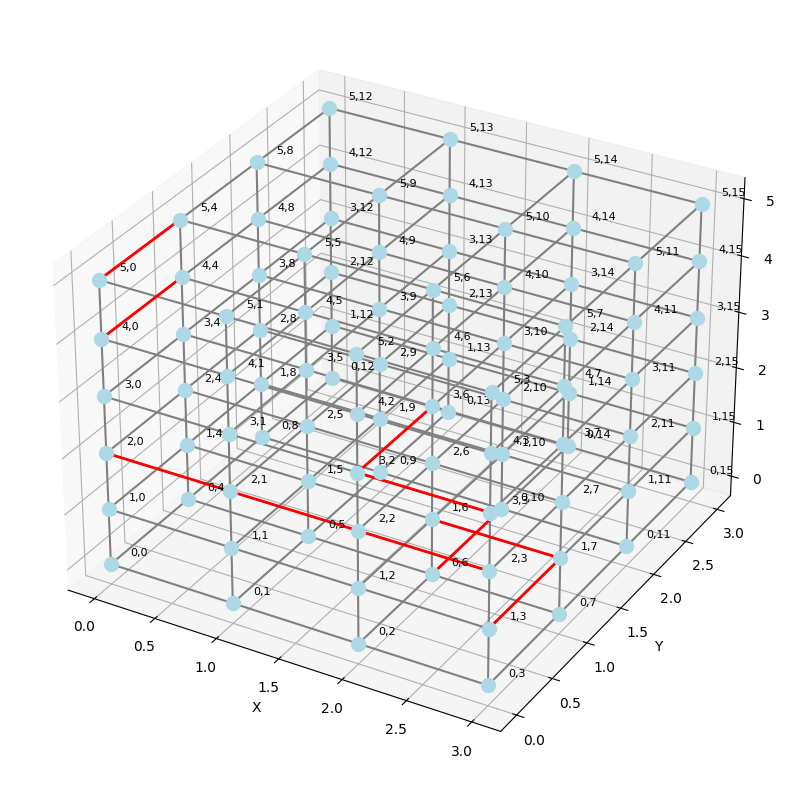

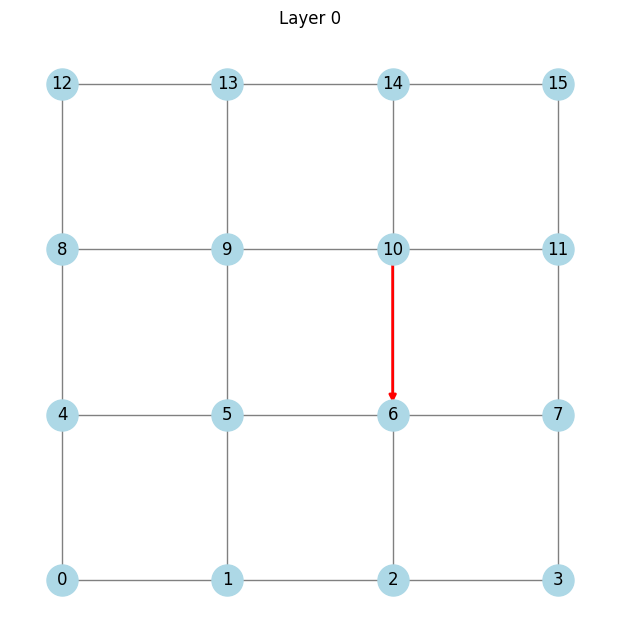

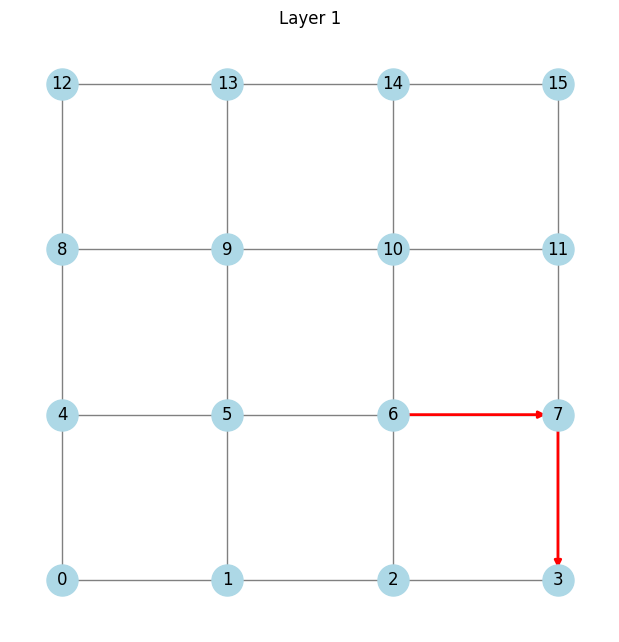

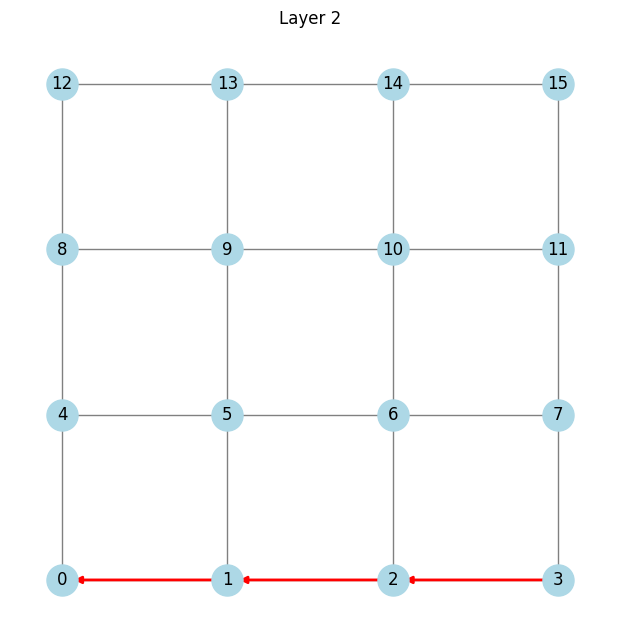

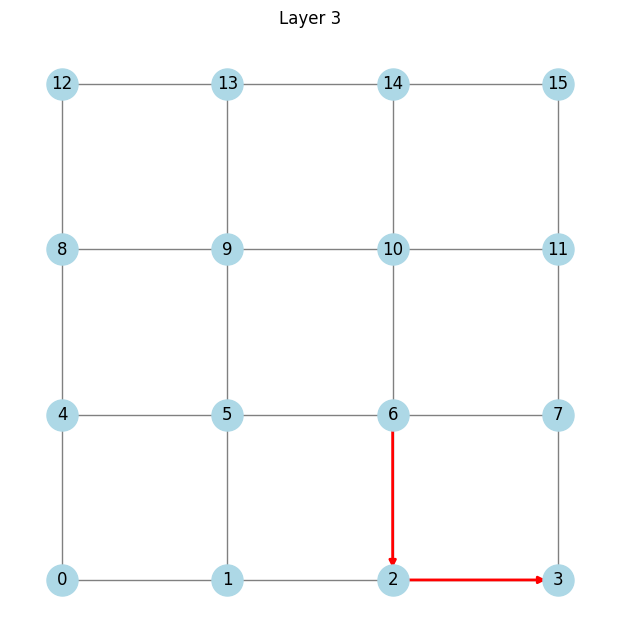

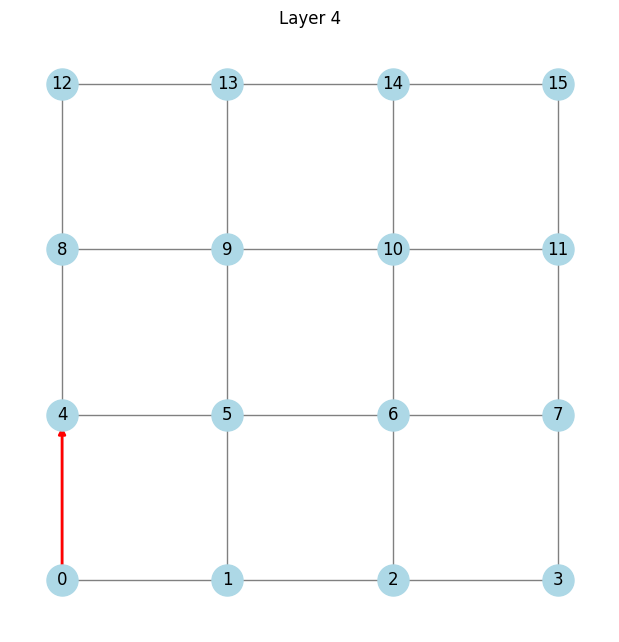

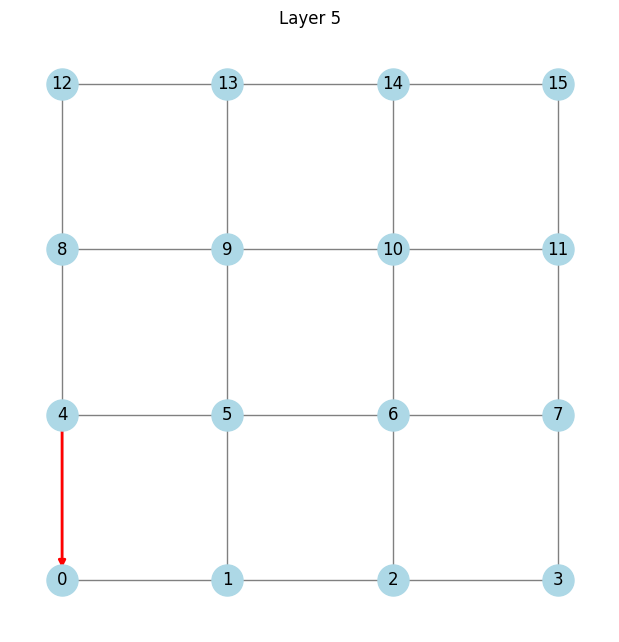

Plot saved to graph_plot.pkl


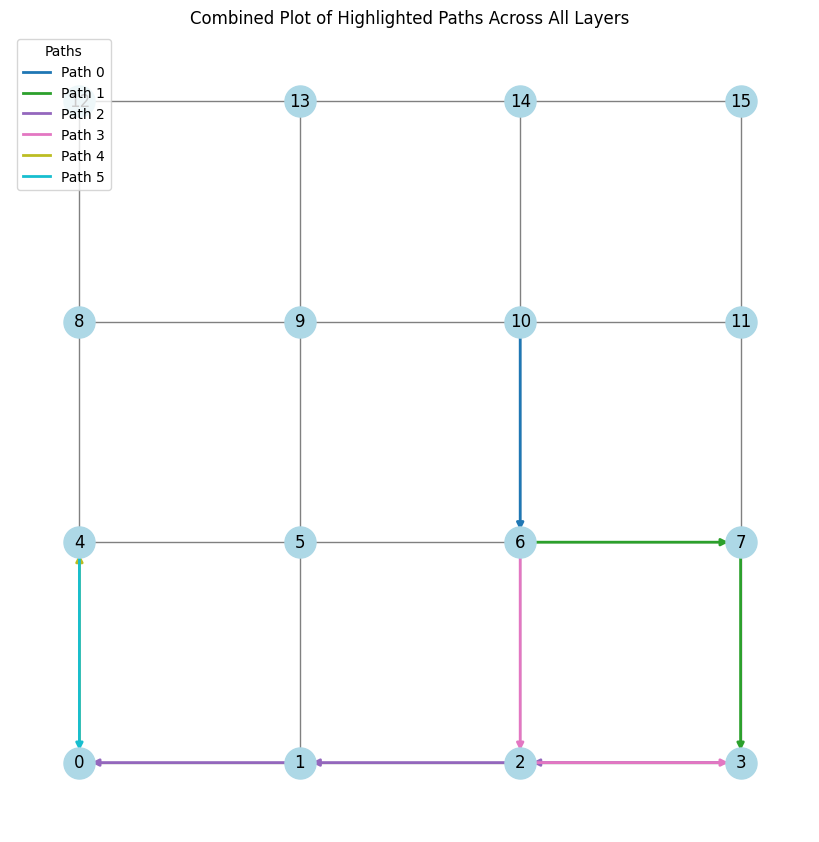

In [35]:
import gurobipy as gp
from gurobipy import GRB	
from pulp import GUROBI

model = LpProblem(name='shortest_path', sense=LpMinimize)
# model= gp.Model("ShortestPath")
# G =CreateNetworkXGraphManuelParallel()

M = 100
dst_num=len(hop_count)
src_num=len(hop_count)

layer_num=max(dst_num,src_num)

# length_list=[2,1,2,1,1,1]
# comb_groups = [["src_0","src_1","src_2","src_3","dst_4"],["dst_1","dst_0","dst_2","dst_5"],["dst_3","src_4","src_5"]]
length_list=hop_count
comb_groups=same_value_groups
# ======================================================================
# edges
# ======================================================================

# create one variable for each edge of the graph/NoC
edges = { (k,i, j): LpVariable(f"edge_{k}_{i}_{j}", cat="Binary") 
      for i, j in G_NoC.edges 
      for k in range(layer_num) }

# edge can only be active in one layer
for i, j in G_NoC.edges:
    model += lpSum(edges[k, i, j] for k in range(layer_num)) <= 1



# ======================================================================
# variables to map destinations and sources to nodes
# ======================================================================

# dst 0 mapped to layer 0, 1-->1, etc
dst_vars = {f"dst_{i}": {node: LpVariable(f"dst_{i}_{node}", cat="Binary") for node in G_NoC.nodes} for i in range(dst_num)}


# dst (needs to be mapped to exactly one node)
for i in range(dst_num):
    model += lpSum(dst_vars[f"dst_{i}"][node] for node in G_NoC.nodes) == 1


src_vars = {f"src_{i}": {node: LpVariable(f"src_{i}_{node}", cat="Binary") for node in G_NoC.nodes} for i in range(src_num)}

for i in range( src_num ):
    model += lpSum(src_vars[f"src_{i}"][node] for node in G_NoC.nodes) == 1



# ======================================================================
# position variables to enforce an order and intermediate nodes
# ======================================================================

# var to indicate the position in the order of the nodes
pos = {(k,node): LpVariable(f"pos_{k}_{node}", lowBound=0, cat="Integer") for node in G_NoC.nodes for k in range(layer_num)}

# Ensure that if an edge exists from node 1 to 2, then pos[2] = pos[1] + 1
for i, j in G_NoC.edges:
    for k in range(layer_num):
        model += pos[k,j]>=pos[k,i]-M*(1-edges[k,i,j])  + 1
        model += pos[k,j]<=pos[k,i]+M*(1-edges[k,i,j])  + 1

# Define the position of each dst and src variable 
pos_dst = {f"dst_{i}": LpVariable(f"pos_dst_{i}", cat="Integer") for i in range(dst_num)}

# If dst i is mapped to node j, then pos_dst[i] = pos[j]
for i in range(dst_num):
    for node in G_NoC.nodes:
        model += pos_dst[f"dst_{i}"] >= pos[i,node] - M * (1 - dst_vars[f"dst_{i}"][node])
        model += pos_dst[f"dst_{i}"] <= pos[i,node] + M * (1 - dst_vars[f"dst_{i}"][node])

pos_src = {f"src_{i}": LpVariable(f"pos_src_{i}", cat="Integer") for i in range(src_num)}

for i in range(src_num):
    for node in G_NoC.nodes:
        model += pos_src[f"src_{i}"] >= pos[i,node] - M * (1 - src_vars[f"src_{i}"][node])
        model += pos_src[f"src_{i}"] <= pos[i,node] + M * (1 - src_vars[f"src_{i}"][node])

# all src positions should be 0
for i in range(src_num):
    model += pos_src[f"src_{i}"] == 0

# if a node has no inputs or outputs its pos should be 0 so it has no effect on sum(pos)
for node in G_NoC.nodes:
    for k in range(layer_num):
        model += pos[k,node] <= M*(lpSum(edges[k,i, j] for i, j in G_NoC.edges if i == node) + lpSum(edges[k,i, j] for i, j in G_NoC.edges if j == node))

# ======================================================================
# Define groups of destinations and sources that should be mapped to the same node
# ======================================================================

# comb_groups = [["src_0", "src_3"],["src_1","src_2","dst_0"],["dst_1","dst_2","dst_3"]]
# comb_groups = [[]]
# comb_groups = [["src_0","src_1","src_2","src_3","src_5","dst_4"],["dst_0","dst_1","dst_2","dst_5"],["dst_3","src_4"]]
# comb_groups = [["src_0","src_1"],["dst_1","dst_0"]]
comb_groups = [list(set(group)) for group in comb_groups] # Ensure each object in the comb_groups list is unique

# The while loop iterates through the `comb_groups` list and merges any groups that share common elements.
i = 0
while i < len(comb_groups):
    j = i + 1
    while j < len(comb_groups):
        # Check if the two groups share any common elements
        if any(item in comb_groups[i] for item in comb_groups[j]):
            # Merge the two groups
            comb_groups[i] = list(set(comb_groups[i] + comb_groups[j]))
            # Remove the merged group
            del comb_groups[j]
        else:
            j += 1
    i += 1

# All elements in the same group should be mapped to the same node
for node in G_NoC.nodes:
    for comb_group in comb_groups:
        for idx,entry1 in enumerate(comb_group[:-1]):
            entry2=comb_group[idx + 1]
            if "src" in entry1 and "src" in entry2:
                model += src_vars[entry1][node] == src_vars[entry2][node]
            elif "dst" in entry1 and "dst" in entry2:
                model += dst_vars[entry1][node] == dst_vars[entry2][node]
            elif "src" in entry1 and "dst" in entry2:
                model += src_vars[entry1][node] == dst_vars[entry2][node]
            elif "dst" in entry1 and "src" in entry2:
                model += dst_vars[entry1][node] == src_vars[entry2][node]
            else:
                raise ValueError(f"Invalid entry in comb_group: {entry1}, {entry2}")

# all elements not in the same group should be mapped to different nodes
not_in_group_pairs = []
all_sources = [f"src_{i}" for i in range(src_num)]
all_destinations = [f"dst_{i}" for i in range(dst_num)]
all_entries = all_sources + all_destinations

for entry1, entry2 in combinations(all_entries, 2):
    in_same_group = any(entry1 in group and entry2 in group for group in comb_groups)
    if not in_same_group:
        not_in_group_pairs.append((entry1, entry2))


for node in G_NoC.nodes:
    for pair in not_in_group_pairs:
        entry1, entry2 = pair
        if "src" in entry1 and "src" in entry2:
            model += src_vars[entry1][node] + src_vars[entry2][node]<=1
        elif "dst" in entry1 and "dst" in entry2:
            model += dst_vars[entry1][node] + dst_vars[entry2][node]<=1
        elif "src" in entry1 and "dst" in entry2:
            model += src_vars[entry1][node] + dst_vars[entry2][node]<=1
        elif "dst" in entry1 and "src" in entry2:
            model += dst_vars[entry1][node] + src_vars[entry2][node]<=1
        else:
            raise ValueError(f"Invalid entry in pair: {entry1}, {entry2}")

# model +=dst_vars["dst_0"][11] == 1
# model +=dst_vars["dst_1"][2] == 1

# model +=src_vars["src_0"][8] == 1
# model +=src_vars["src_1"][14] == 1
# ======================================================================
# Flow conditions to src, dst and intermediate nodes
# ======================================================================

for node in G_NoC.nodes:
    for k in range(layer_num):
        # Balance condition (same number out as in) for all not specific nodes (nodes which are not src or dst)
        model += (lpSum(edges[k,i, j] for i, j in G_NoC.edges if i == node) - lpSum(edges[k,i, j] for i, j in G_NoC.edges if j == node)) <= 0 + M * (src_vars[f"src_{k}"][node]+ dst_vars[f"dst_{k}"][node])
        model += (lpSum(edges[k,i, j] for i, j in G_NoC.edges if i == node) - lpSum(edges[k,i, j] for i, j in G_NoC.edges if j == node)) >= 0 - M * (src_vars[f"src_{k}"][node]+ dst_vars[f"dst_{k}"][node])
        
        #intermediate nodes can have max one input and one output because they are considered as real intermediate nodes of the task graph. Two paths can share an intermediate task.
        #intermediate nodes always have to be considered as a real task node. No "just passing" nodes are possible
        # model += (lpSum(x[i, j] for i, j in G_NoC.edges if i == node) - lpSum(x[i, j] for i, j in G_NoC.edges if j == node)) <= 1

        dst_var = dst_vars[f"dst_{k}"]
        
        model += lpSum(edges[k,i, j] for i, j in G_NoC.edges if j == node) <= 1 + M * (1 - dst_var[node])  # One incoming edge
        model += lpSum(edges[k,i, j] for i, j in G_NoC.edges if j == node) >= 1 - M * (1 - dst_var[node])

        model += lpSum(edges[k,i, j] for i, j in G_NoC.edges if i == node) <= 0 + M * (1 - dst_var[node])  # No outgoing edge
        model += lpSum(edges[k,i, j] for i, j in G_NoC.edges if i == node) >= 0 - M * (1 - dst_var[node])


        src_var = src_vars[f"src_{k}"]
        
        model += lpSum(edges[k,i, j] for i, j in G_NoC.edges if j == node) <= 0 + M * (1 - src_var[node])  # No incoming edge
        model += lpSum(edges[k,i, j] for i, j in G_NoC.edges if j == node) >= 0 - M * (1 - src_var[node])

        model += lpSum(edges[k,i, j] for i, j in G_NoC.edges if i == node) <= 1 + M * (1 - src_var[node])  # One outgoing edge
        model += lpSum(edges[k,i, j] for i, j in G_NoC.edges if i == node) >= 1 - M * (1 - src_var[node])

# ======================================================================
# Nodes can not be used twice as intermediate nodes
# ======================================================================

# is a src or dst mapped to this node
src_dst = {node: LpVariable(f"src_dst_node{node}", cat="Binary") for node in G_NoC.nodes}

for node in G_NoC.nodes:
    for m in range(dst_num):
        model +=src_dst[node] >=dst_vars[f"dst_{m}"][node]
        model +=src_dst[node] >=src_vars[f"src_{m}"][node]
    model += src_dst[node] <= lpSum(dst_vars[f"dst_{m}"][node] for m in range(dst_num)) + lpSum(src_vars[f"src_{m}"][node] for m in range(src_num))


# is there an input AND an output for this node (is it an intermediate node)
in_out = {(k, node): LpVariable(f"inout_layer{k}_node{node}", cat="Binary") for node in G_NoC.nodes for k in range(layer_num)}

for node in G_NoC.nodes:
    for k in range(layer_num):
        model += in_out[k, node] >= lpSum(edges[k, i, j] for i, j in G_NoC.edges if i == node) + lpSum(edges[k, i, j] for i, j in G_NoC.edges if j == node) - 1
        model += in_out[k, node] <= lpSum(edges[k, i, j] for i, j in G_NoC.edges if i == node) + lpSum(edges[k, i, j] for i, j in G_NoC.edges if j == node)
        

# (input or output) AND (src or dst) -> path_add_individual
# use a src or dst node as an intermediate node -> can not use it as normal intermediate node -> total hops +1
path_add_individual = {(k,node): LpVariable(f"path_add_individual{k}_{node}", lowBound=0, cat="Integer") for node in G_NoC.nodes for k in range(layer_num)}
for node in G_NoC.nodes:
    for k in range(layer_num):
        model += path_add_individual[k,node] >= in_out[k, node] + src_dst[node] - 1
        model += path_add_individual[k,node] <= in_out[k, node]
        model += path_add_individual[k,node] <= src_dst[node]


# how often is a node used as an intermediate node (intermediate node if in one path the node has both input and output)
in_out_total={node: LpVariable(f"inout_total_node{node}", lowBound=0, cat="Integer") for node in G_NoC.nodes}
for node in G_NoC.nodes:
    model += in_out_total[node] == lpSum(in_out[k, node] for k in range(layer_num))

# The node is used as an intermediate node in at least 2 paths (if a>1: b=1 elif a=<1: b=0)
in_out_total_norm={node: LpVariable(f"inout_total_norm{node}", lowBound=0, cat="Integer") for node in G_NoC.nodes}
for node in G_NoC.nodes:
    model += in_out_total[node] -1 <= M*in_out_total_norm[node]
    model += in_out_total[node] -1 >= -M*(1-in_out_total_norm[node])


# is this node an intermediate node and used in at least 2 paths
multi_use_node = {(k,node): LpVariable(f"path_add_individual_2_{k}_{node}", lowBound=0, cat="Integer") for node in G_NoC.nodes for k in range(layer_num)}
for node in G_NoC.nodes:
    for k in range(layer_num):
        # check if something is mapped to this node
        is_pos_nonzero = LpVariable(f"is_pos_nonzero_{k}_{node}", cat="Binary")
        model += pos[k, node] <= is_pos_nonzero * M  # Upper bound
        model += pos[k, node] >= 1 - (1 - is_pos_nonzero) * M  # Lower bound
        
        # something is mapped to the node and it is an intermediate node in at least 2 paths and it it no destination node (because the penalty for using a destination node as a intermediate node is already applied)
        model += multi_use_node[k, node] <= is_pos_nonzero
        model += multi_use_node[k, node] <= in_out_total_norm[node]
        model += multi_use_node[k, node] <= 1 - dst_vars[f"dst_{k}"][node]
        model += multi_use_node[k, node] >= is_pos_nonzero + in_out_total_norm[node] - dst_vars[f"dst_{k}"][node] -1


# choose which path is allowed to use the multiple times used intermediate node
choose_mid_node = {(k,node): LpVariable(f"choose_mid_{k}_node{node}", cat="Binary") for node in G_NoC.nodes for k in range(layer_num)}
for node in G_NoC.nodes:
    model += lpSum(choose_mid_node[k,node] for k in range(layer_num)) == 1

# path_add_individual2 is the additional cost/length that is added to a path if it uses one of the multi use hops. If this path is chosen we do not need to add anything (because if multiple paths want to use one intermediate node, one path is allowed to do so)
path_add_individual2 = {(k,node): LpVariable(f"path_add_individual_3_{k}_{node}", lowBound=0, cat="Integer") for node in G_NoC.nodes for k in range(layer_num)}
for node in G_NoC.nodes:
    for k in range(layer_num):
        model +=path_add_individual2[k, node] <= multi_use_node[k, node]
        model +=path_add_individual2[k, node] <= 1-choose_mid_node[k, node]
        model +=path_add_individual2[k, node] >= multi_use_node[k, node] - choose_mid_node[k, node]


# total number of hops needed to add to each path
path_add_total = {k: LpVariable(f"path_add_total_{k}", lowBound=0, cat="Integer") for k in range(layer_num)}

for k in range(layer_num):
    model += path_add_total[k] == lpSum(path_add_individual[k, node] for node in G_NoC.nodes) + lpSum(path_add_individual2[k, node] for node in G_NoC.nodes)

# ======================================================================
# set length of the paths (number of hops) with positions of destination
# ======================================================================
# length_list=[1,2,3,2]
# length_list=[2,1,2,1,1,1]
# length_list=[2,1]
# model += pos_dst[f"dst_1"] ==2
for i in range(dst_num):
    model += pos_dst[f"dst_{i}"] >= length_list[i] +path_add_total[i]


# ======================================================================
# Optimization objectives
# ======================================================================

# Define variables for the maximum pos_dst -> minimize longest path
max_pos_dst = LpVariable("max_pos_dst", lowBound=0, cat="Integer")

for dst_key, var in pos_dst.items():
    model += max_pos_dst >= var

# sum of positions of all nodes including all intermediate nodes
# model += lpSum(edges[k, i, j] for i, j in G_NoC.edges for k in range(layer_num))


# model += pos_dst["dst_0"]
# model +=max_pos_dst

# sum of all path lengths
model += lpSum(pos_dst[f"dst_{i}"] for i in range(dst_num))



# status = model.solve(GUROBI_CMD(threads=26, options=[("IIS", 1), ("IISFile", "/home/sfischer/Documents/projects/wk_LinProg/LinProg_Scripts/infeasible.ilp")]))
status = model.solve(GUROBI_CMD(threads=26, timeLimit=60))
# status = model.solve(GUROBI(Threads=26, TimeLimit=600,ImprovementTime=30))

# status = model.solve(GUROBI_CMD(threads=26))

# model.computeIIS()
# model.write('/home/sfischer/Documents/projects/wk_LinProg/LinProg_Scripts/infeasible.ilp')
model.writeLP("/home/sfischer/Documents/projects/wk_LinProg/LinProg_Scripts/model.lp")
# ======================================================================
# Debug information
# ======================================================================

print(f"Objective value: {model.objective.value()}")

if debug==True:
    edge_list = []
    if status == 1:  # Check if the solution is optimal
        print("Optimal solution found:")
        for (k, i, j), var in edges.items():
            if var.value() > 0:  # Only print edges that are part of the solution
                print(f"Edge ({k},{i}, {j}) is part of the shortest path with value: {var.value()}")
                edge_list.append((k,i,j))
    else:
        print(f"Problem status: {LpStatus[status]}")





    # Print all source nodes from src_vars
    for src_key, src_dict in src_vars.items():
        for node, var in src_dict.items():
            if var.value() == 1:
                print(f"Source node for {src_key}: {node}")

    # Print all destination nodes from dst_vars
    for dst_key, dst_dict in dst_vars.items():
        for node, var in dst_dict.items():
            if var.value() == 1:
                print(f"Destination node for {dst_key}: {node}")


    for node, var in pos.items():
        print(f"Position of node {node}: {var.value()}")

    # Print the positions of all source nodes
    for src_key, var in pos_src.items():
        print(f"Source position ({src_key}): {var.value()}")

    # Print the positions of all destination nodes
    for dst_key, var in pos_dst.items():
        print(f"Destination position ({dst_key}): {var.value()}")


    # Print all variables and their values
    for v in model.variables():
        print(f"{v.name} = {v.value()}")
        
    print(edge_list)

    highlight_edges_with_colors = {
    (1, 9): "red",
    (11, 3): "blue",
    (5, 7): "green"
    }

    draw_folded_torus_noc(
        mesh_size=4,
        G_NoC=G_NoC,
        highlight_edges_with_colors=convert_edge_list_to_highlight_dict(edge_list),
        title="Folded Torus NoC (4x4)"
    )


    plot_nx4x4_grid_with_highlighted_edges(edge_list)


In [36]:
# import gurobipy as gp
# from gurobipy import GRB

# # Create model
# model = gp.Model("shortest_path")

# M = 100
# dst_num = len(hop_count)
# src_num = len(hop_count)
# layer_num = max(dst_num, src_num)
# length_list = hop_count
# comb_groups = same_value_groups

# # Variables
# edges = model.addVars(
#     [(k, i, j) for i, j in G_NoC.edges for k in range(layer_num)],
#     vtype=GRB.BINARY,
#     name="edge"
# )

# dst_vars = model.addVars(
#     [(i, node) for i in range(dst_num) for node in G_NoC.nodes],
#     vtype=GRB.BINARY,
#     name="dst"
# )

# src_vars = model.addVars(
#     [(i, node) for i in range(src_num) for node in G_NoC.nodes],
#     vtype=GRB.BINARY,
#     name="src"
# )

# pos = model.addVars(
#     [(k, node) for node in G_NoC.nodes for k in range(layer_num)],
#     vtype=GRB.INTEGER,
#     lb=0,
#     name="pos"
# )

# pos_dst = model.addVars(
#     [i for i in range(dst_num)],
#     vtype=GRB.INTEGER,
#     name="pos_dst"
# )

# pos_src = model.addVars(
#     [i for i in range(src_num)],
#     vtype=GRB.INTEGER,
#     name="pos_src"
# )

# # ... (define all other variables similarly using model.addVars or model.addVar) ...

# # Constraints
# # Example: edge can only be active in one layer
# for i, j in G_NoC.edges:
#     model.addConstr(gp.quicksum(edges[k, i, j] for k in range(layer_num)) <= 1)

# # Example: dst (needs to be mapped to exactly one node)
# for i in range(dst_num):
#     model.addConstr(gp.quicksum(dst_vars[i, node] for node in G_NoC.nodes) == 1)

# # Example: src (needs to be mapped to exactly one node)
# for i in range(src_num):
#     model.addConstr(gp.quicksum(src_vars[i, node] for node in G_NoC.nodes) == 1)

# # ... (translate all other constraints using model.addConstr or model.addConstrs) ...

# # Objective
# model.setObjective(gp.quicksum(pos_dst[i] for i in range(dst_num)), GRB.MINIMIZE)

# # Set Gurobi parameters
# model.setParam("Threads", 26)
# model.setParam("TimeLimit", 600)
# model.setParam("ImprovementTime", 30)

# # Optimize
# model.optimize()

# # Debug information
# if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
#     print(f"Objective value: {model.ObjVal}")
#     # Print solution values as needed
#     for v in model.getVars():
#         print(f"{v.VarName} = {v.X}")
# else:
#     print(f"Problem status: {model.Status}")

# # Save model to file
# # model.write("/home/sfischer/Documents/projects/wk_LinProg/LinProg_Scripts/model.lp")

In [37]:
# ======================================================================
# Convert result into information usable to generate mapping files
# ======================================================================


# ======================================================================
# Where are the src and dst mapped to
# ======================================================================
src_dst_nodes = set()
all_nodes= set()
not_mapped=set()
for src_key, src_dict in src_vars.items():
    for node, var in src_dict.items():
        if var.value() == 1:
            src_dst_nodes.add(src_dst_mapping[src_key])

for dst_key, dst_dict in dst_vars.items():
    for node, var in dst_dict.items():
        if var.value() == 1:
            src_dst_nodes.add(src_dst_mapping[dst_key])

# ======================================================================
# What tasks are mapped together
# ======================================================================
combined_mapping_dict = {}

with open("CombinedMapping.txt", "r") as file:
    for line in file:
        if line.strip():  # Ignore empty lines
            # Split the line into router and tasks
            router, tasks = line.split(":")
            router = router.strip().replace("Router ", "")  # Extract router number
            tasks = tasks.strip().replace("Tasks [", "").replace("]", "")  # Extract tasks
            task_list = [int(task.strip()) for task in tasks.split(",")]  # Convert tasks to a list of integers
            combined_mapping_dict[int(router)] = task_list

# ======================================================================
# What nodes are not mapped yet (intermediate nodes)
# ======================================================================
for key,value in combined_mapping_dict.items():
    all_nodes.add(key)

not_mapped = all_nodes - set(map(int, src_dst_nodes))
not_mapped_dict = {}

for node in not_mapped:
    not_mapped_dict[node] = {
        "path": None,  # Placeholder for path value
        "mapping": None  # Placeholder for mapping value
    }

# ======================================================================
# Create a graph from the edges to easily work with paths
# ======================================================================
shortest_path=[]
for k in range(layer_num):
    G_layer = nx.DiGraph()
    active_edges = []
    for (layer, i, j), var in edges.items():
        if layer == k and var.value() == 1:
            active_edges.append((i, j))
            G_layer.add_edge(i, j)

    src_node_layer = [node for node in G_layer.nodes if G_layer.in_degree(node) == 0 and G_layer.out_degree(node) > 0]
    dst_node_layer = [node for node in G_layer.nodes if G_layer.out_degree(node) == 0 and G_layer.in_degree(node) > 0]
    
    shortest_path.append(nx.shortest_path(G_layer, source=src_node_layer[0], target=dst_node_layer[0]))


# ======================================================================
# Where can the intermediate nodes be mapped to (check chose var)
# ======================================================================

available_nodes = {}

for i in range(layer_num):
    for m in shortest_path[i][1:-1]:
        if i not in available_nodes:
            available_nodes[i] = []
        if in_out_total_norm[m].value()==1 and choose_mid_node[i,m].value()==1:
            available_nodes[i].append(m)
        if in_out_total_norm[m].value()==0:
            available_nodes[i].append(m)


split_list = []

# ======================================================================
# choose the value closest to the src so that multiple intermediate nodes are mapped in the right order
# ======================================================================
mapping={}
for node,atr in not_mapped_dict.items():
    for idx,i in enumerate(parallel_paths):
        if str(node) in i:
            atr["path"]=idx
            chosen_value = available_nodes[idx][0]
            atr["mapping"] = chosen_value
            mapping[str(node)] =chosen_value
            available_nodes[idx].remove(chosen_value)


# ======================================================================
# combine the mapping of intermediate node and src + dst
# ======================================================================

for dst_key, dst_dict in dst_vars.items():
    for node, var in dst_dict.items():
        if var.value() == 1:
            mapping[src_dst_mapping[dst_key]] = node

for src_key, src_dict in src_vars.items():
    for node, var in src_dict.items():
        if var.value() == 1:
            mapping[src_dst_mapping[src_key]] = node


# ======================================================================
# For the circuit switched configuration each connection between two nodes
# needs to be a separate path -> split the original path depending on intermediate nodes
# ======================================================================
split_points=[]

for m in range(len(shortest_path)):
    split_points.append([])
    for node,atr in not_mapped_dict.items():

        if int(atr["path"])==m:
            split_points[m].append(int(atr["mapping"]))


result_list = []
for idx,value in enumerate(shortest_path):
    original_list = value
    split_point=split_points[idx]
    result = []
    current_sublist = []

    for item in original_list:
        current_sublist.append(item)
        if item in split_point:
            result.append(current_sublist)
            current_sublist = [item]

    if current_sublist:
        result.append(current_sublist)

    result_list+=result
shortest_path=result_list

In [38]:
import json

# Data to save
data_to_save = {
    "combined_mapping_dict": combined_mapping_dict,
    "mapping": mapping,
    "shortest_path": shortest_path
}

# Save to a JSON file
with open("LinProgResults.json", "w") as json_file:
    json.dump(data_to_save, json_file, indent=4)
